In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression
from sidecar import Sidecar

import sys
sys.path.append("..")
from src import definitions as defs
from src import features, models

plt.rcParams['figure.max_open_warning'] = 0

In [2]:
wdir = defs.ROOT / "data"

In [3]:
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)

freq = data.index[1] - data.index[0]
n_per_hour = pd.Timedelta("1 hour") / freq

data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))
data.elevation = data.elevation.interpolate(method="time", limit=1, limit_direction="both")

In [23]:
daily = data.elevation.groupby(by=pd.Grouper(freq="D")).mean().interpolate(method="time", limit_direction="both")
res = STL(endog=daily, period=365, seasonal=365, trend=365*5).fit()
data["trend"] = res.trend.reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["detrended"] = data.elevation - data.trend + data.trend.iat[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
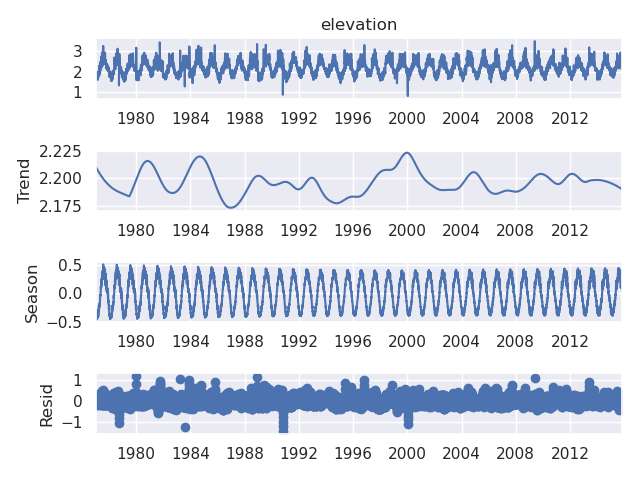

In [24]:
res.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
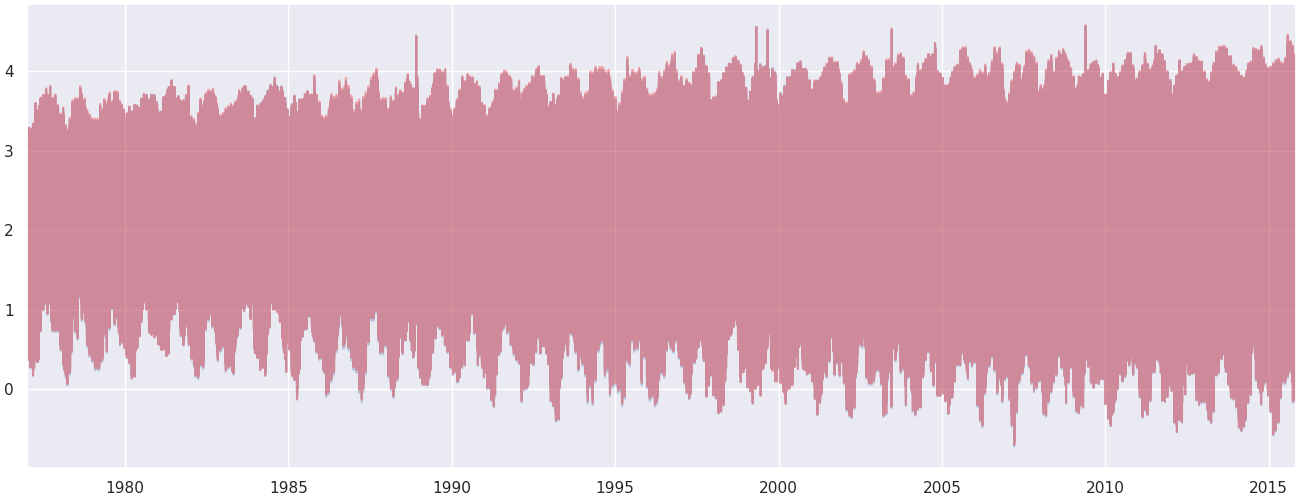

In [25]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

data.elevation.plot(ax=ax, alpha=0.3);
data.detrended.plot(ax=ax, alpha=0.3, color="red");

ax.set_xlabel("");

In [6]:
data = data.detrended.to_frame(name="elevation")

In [7]:
data[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]
data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [8]:
dt = pd.Timedelta("30 days")
stds = 3
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_for_roll = data.loc[data.high == True].loc[data.loc[data.high == True].elevation.between(bot, top)].elevation

r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_for_roll = data.loc[data.low == True].loc[data.loc[data.low == True].elevation.between(bot, top)].elevation

In [9]:
highs_excl = data.loc[data.high == True].loc[data.loc[data.high == True].index.difference(other=highs_for_roll.index)]
lows_excl = data.loc[data.low == True].loc[data.loc[data.low == True].index.difference(other=lows_for_roll.index)]

In [10]:
data["high_roll"] = highs_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = lows_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [11]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=-1, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

In [12]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [13]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
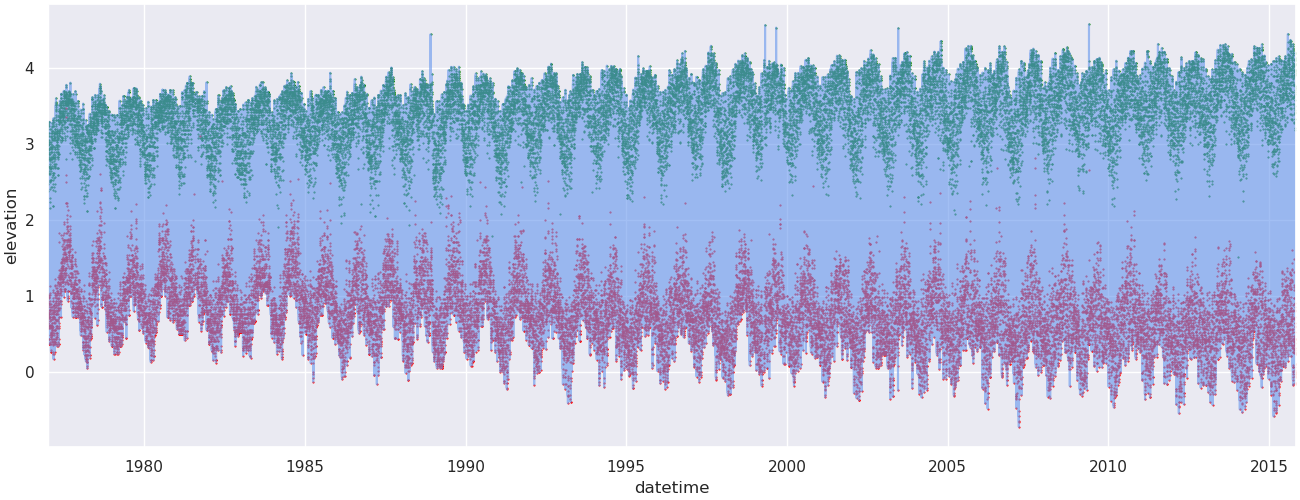

In [14]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

data.elevation.plot(ax=ax, color="cornflowerblue", alpha=0.6);
data.elevation.loc[data.high == True].reset_index().plot(kind="scatter", x="datetime", y="elevation", color="green", marker=".", s=1, ax=ax);
data.elevation.loc[data.low == True].reset_index().plot(kind="scatter", x="datetime", y="elevation", color="red", marker=".", s=1, ax=ax);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
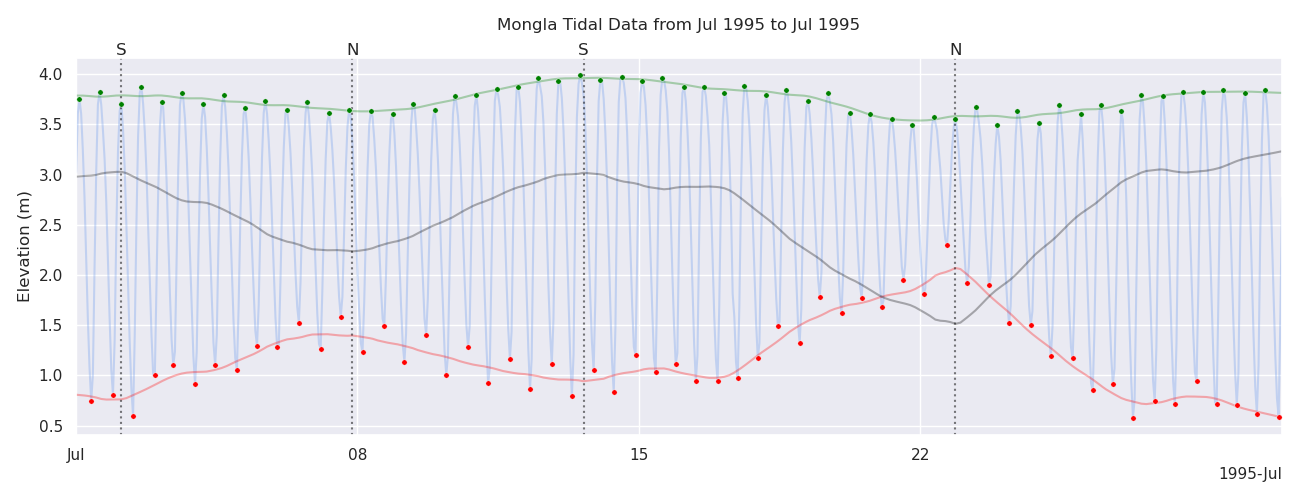

In [15]:
start = pd.to_datetime("1995-07-01")
end = start + pd.Timedelta("30D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [16]:
data[["high", "low"]] = False
data.loc[highs_for_roll.index, "high"] = True
data.loc[lows_for_roll.index, "low"] = True

In [17]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], ts))

In [18]:
subset = data.loc[data.index[-1] - pd.Timedelta("365.25 D") * 18.61 * 2:]

H = subset.high_smooth.loc[data.high == True].agg(func=lm_tides, ref_date=data.index[0])
L = subset.low_smooth.loc[data.low == True].agg(func=lm_tides, ref_date=data.index[0])

SH = subset.high_smooth.loc[data.spring == True].agg(func=lm_tides, ref_date=data.index[0])
SL = subset.low_smooth.loc[data.spring == True].agg(func=lm_tides, ref_date=data.index[0])

NH = subset.high_smooth.loc[data.neap == True].agg(func=lm_tides, ref_date=data.index[0])
NL = subset.low_smooth.loc[data.neap == True].agg(func=lm_tides, ref_date=data.index[0])

objs = [SH, H, NH, NL, L, SL]
keys = ["SH", "H", "NH", "NL", "L", "SL"]

lms = dict(zip(keys, objs))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
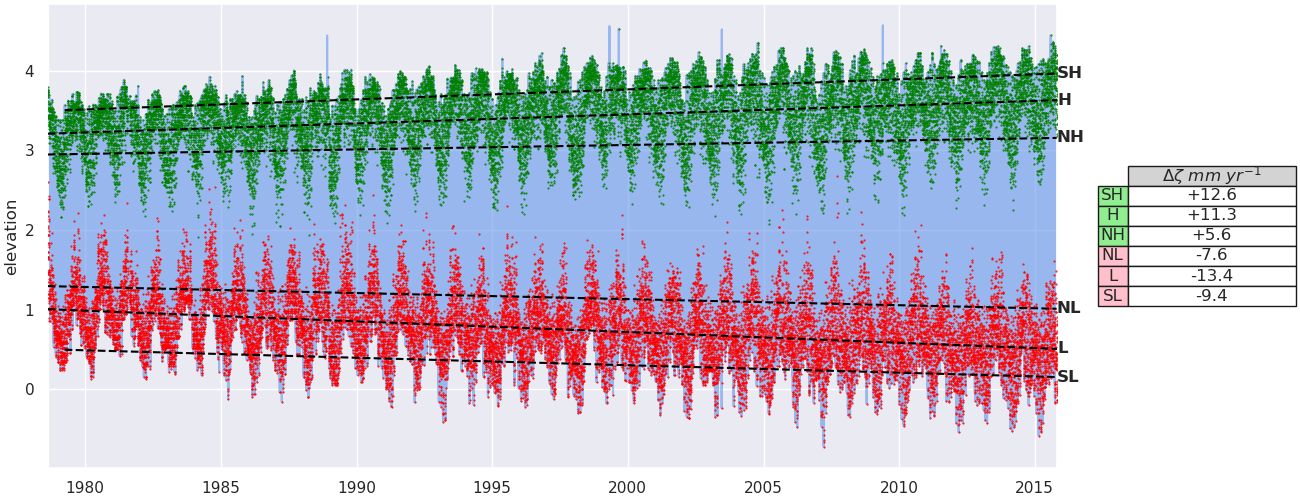

In [19]:
fig, (ax, tabax) = plt.subplots(figsize=(13, 5), ncols=2, gridspec_kw={'width_ratios': [6, 1]}, constrained_layout=True)

subset.elevation.plot(kind="line", ax=ax, color="cornflowerblue", alpha=0.6, zorder=1);
subset.elevation.loc[data.high == True].reset_index().plot(kind="scatter", x="datetime", y="elevation", color="green", marker=".", s=1, ax=ax, zorder=10);
subset.elevation.loc[data.low == True].reset_index().plot(kind="scatter", x="datetime", y="elevation", color="red", marker=".", s=1, ax=ax, zorder=10);

cellText = []
rowLabels = []
for name, lm in lms.items():
    cellText.append(["{:+.1f}".format((lm.coef * 1000))])
    rowLabels.append(name)
    lm.ts.plot(ls="--", color="black", ax=ax, zorder=20);
    # ax.text(x=lm.ts.index.mean(), y=lm.ts.mean(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lm.coef * 1000), fontsize="large", fontweight="bold");
    ax.text(x=lm.ts.index.max(), y=lm.ts[-1], ha="left", va="center", zorder=30, s="{}".format(name), fontsize="medium", fontweight="bold");

colLabels = ["$\Delta\zeta\ mm\ yr^{-1}$"]
colColours=["lightgray"]
rowColours=("lightgreen", "lightgreen", "lightgreen", "pink", "pink", "pink")

tabax.axis("off")
tabax.table(cellText=cellText, colLabels=colLabels, rowLabels=rowLabels, rowLoc="center", cellLoc="center", loc='center', colColours=colColours, rowColours=rowColours)
ax.xaxis.label.set_visible(False);
ax.set_xlim(subset.index[0], subset.index[-1]);